In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/22/dpcgnk7915s7wb3h3qgxcz980000gn/T/ipykernel_39369/1526636886.py:5: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

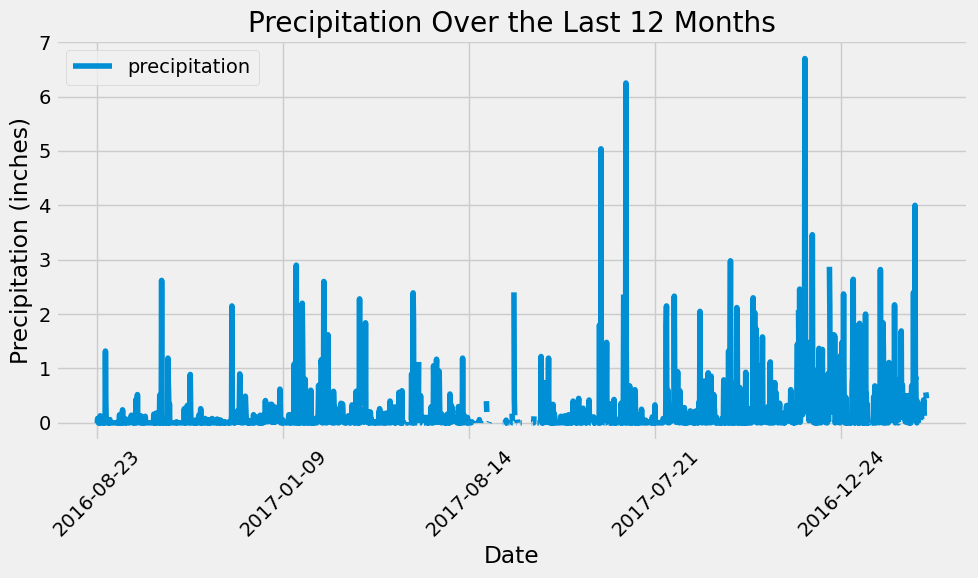

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = dt.datetime.strptime(recent_date.date, "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
one_year_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= recent_date)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_date).all()

# Sort the dataframe by date
precipitation_df = pd.DataFrame(results, columns=['date','precipitation'])
precipitation_df.set_index(precipitation_df['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', figsize=(10, 6))
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_counts[0][0]
temperature_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id).all()

temperature_query

[(54.0, 85.0, 71.66378066378067)]

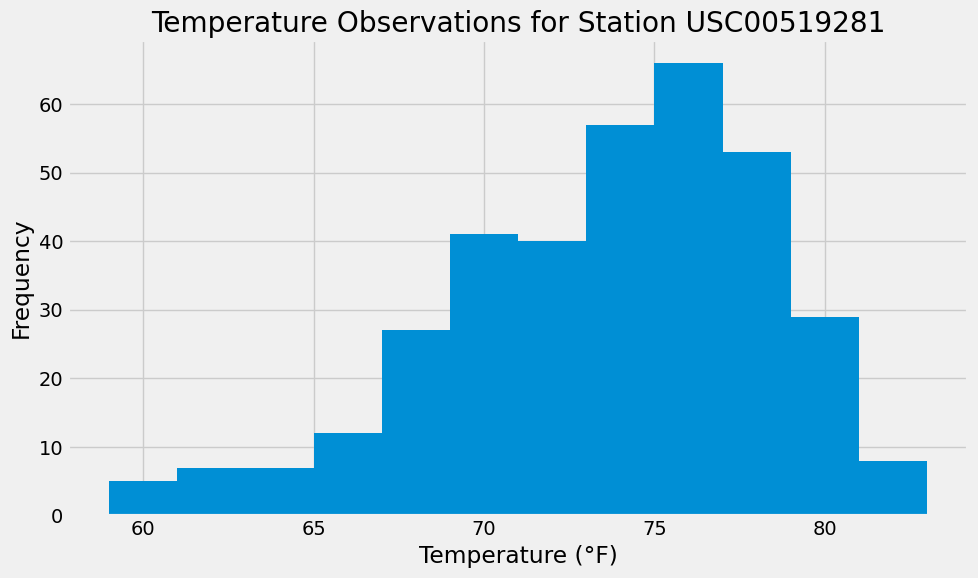

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_date).all()

df = pd.DataFrame(tobs_results, columns=['tobs'])

df.plot.hist(bins=12, figsize=(10, 6), legend=False)
plt.title(f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()